In [11]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, plot_diro2c_tree, \
                           print_diro2c_rules
from baseline import print_rules, plot_tree_leafs_for_class
from tasks.feature_ignored import make_task

In [2]:
clf_a, clf_b, X, y, feature_names = make_task()

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Global explanations

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

## $(0,1)$

In [5]:
focus_class = '(0, 1)'

In [7]:
%%time
explanation = generate_diro2c_explanation(X, 0, comparer, generation_func='global',
                                          focus_class=focus_class, gn_population_size=500)
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 44.1 s, sys: 377 ms, total: 44.5 s
Wall time: 49.9 s


In [6]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [7]:
evaluation_info = explanation['binary_diff_classifer']['evaluation_info']
X_explain, y_explain = evaluation_info['X'], evaluation_info['y']
feature_names = comparer.feature_names
class_names = explanation['class_names']

In [9]:
def explain(max_depth=None, tree_fig_size=(28, 14)):
    global tree
    tree = DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(X_explain, y_explain)
    
    feature_importances = tree.feature_importances_
    feature_order = np.flip(np.argsort(feature_importances))
    fig, ax = plt.subplots(figsize=(5, 2))
    ax.set_title('Relative feature importance')
    ax.scatter(np.flip(feature_importances[feature_order]),
               np.flip(comparer.feature_names[feature_order]))
    ax.set_xlim((0, ax.get_xlim()[1]))
    plt.show()
    
    fig, ax = plt.subplots(figsize=(14, 14))
    plot_tree(tree, feature_names=feature_names, class_names=class_names, ax=ax, node_ids=True, precision=2)
    
    y_test = mclass_diff == np.where(comparer.class_names == focus_class)[0][0]
    print_rules(tree, feature_names, class_names, focus_class, X_test=X, y_test=y_test, precision=2)
    
    plot_tree_leafs_for_class(tree, class_names, focus_class, X, mclass_diff, comparer.class_names, feature_names)
    
    print('\ngenerated data evaluation:')
    print(classification_report(y_explain, tree.predict(X_explain), target_names=class_names))

    print('\noriginal data evaluation:')
    print(classification_report(mclass_diff == np.where(comparer.class_names == focus_class)[0][0], tree.predict(X), target_names=class_names))

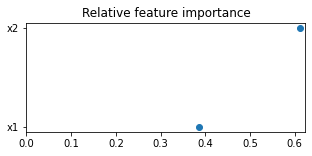

node #7: if (x1 > 119.5) and (x2 > 20.5) and (x2 <= 94.0) then class (0, 1) (covers 0.986 of 768 instances)
node #4: if (x1 <= 119.5) and (x2 > 20.5) and (x2 <= 41.5) then class (0, 1) (covers 0.544 of 147 instances)

generated data evaluation:
              precision    recall  f1-score   support

  not (0, 1)       0.99      0.95      0.97      1490
      (0, 1)       0.91      0.98      0.95       851

    accuracy                           0.96      2341
   macro avg       0.95      0.97      0.96      2341
weighted avg       0.96      0.96      0.96      2341


original data evaluation:
              precision    recall  f1-score   support

  not (0, 1)       0.98      0.90      0.94       278
      (0, 1)       0.38      0.82      0.52        22

    accuracy                           0.89       300
   macro avg       0.68      0.86      0.73       300
weighted avg       0.94      0.89      0.91       300



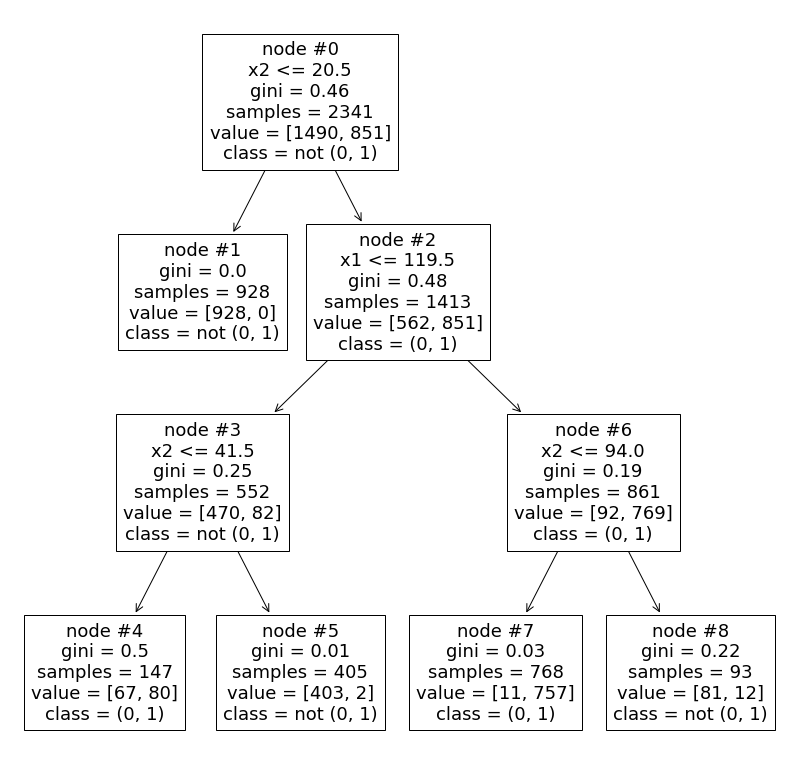

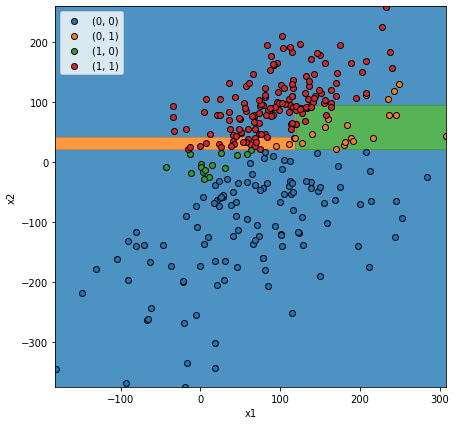

In [12]:
explain(max_depth=3)

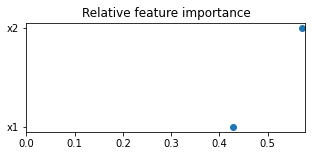

node #12: if (x1 > 119.5) and (x2 > 20.5) and (x2 <= 88.5) then class (0, 1) (covers 0.989 of 758 instances)
node #6: if (x1 > 81.5) and (x1 <= 119.5) and (x2 > 20.5) and (x2 <= 41.5) then class (0, 1) (covers 0.889 of 90 instances)
node #16: if (x1 > 206.5) and (x2 > 94.0) then class (0, 1) (covers 0.917 of 12 instances)
node #13: if (x1 > 119.5) and (x2 > 88.5) and (x2 <= 94.0) then class (0, 1) (covers 0.7 of 10 instances)

generated data evaluation:
              precision    recall  f1-score   support

  not (0, 1)       1.00      0.99      0.99      1490
      (0, 1)       0.97      1.00      0.99       851

    accuracy                           0.99      2341
   macro avg       0.99      0.99      0.99      2341
weighted avg       0.99      0.99      0.99      2341


original data evaluation:
              precision    recall  f1-score   support

  not (0, 1)       1.00      0.94      0.97       278
      (0, 1)       0.56      1.00      0.72        22

    accuracy            

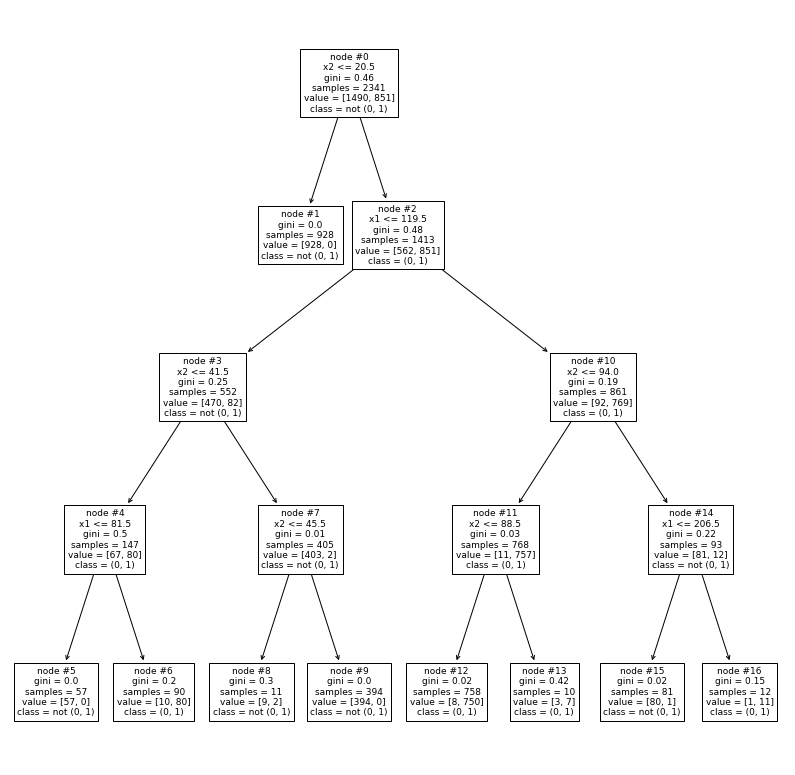

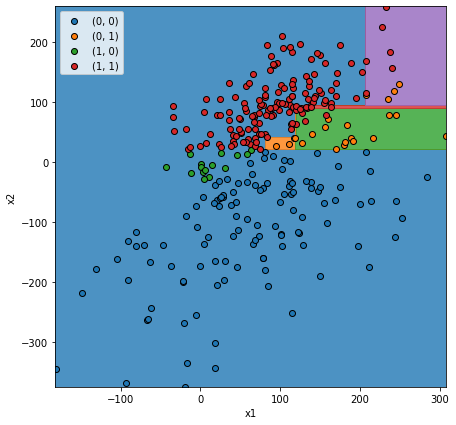

In [13]:
explain(max_depth=4)

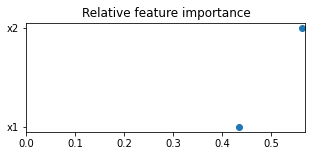

node #18: if (x1 > 126.5) and (x2 > 20.5) and (x2 <= 88.5) then class (0, 1) (covers 0.994 of 722 instances)
node #8: if (x1 > 93.5) and (x1 <= 119.5) and (x2 > 20.5) and (x2 <= 41.5) then class (0, 1) (covers 0.985 of 68 instances)
node #17: if (x1 > 119.5) and (x1 <= 126.5) and (x2 > 20.5) and (x2 <= 88.5) then class (0, 1) (covers 0.889 of 36 instances)
node #7: if (x1 > 81.5) and (x1 <= 93.5) and (x2 > 20.5) and (x2 <= 41.5) then class (0, 1) (covers 0.591 of 22 instances)
node #27: if (x1 > 206.5) and (x2 > 94.0) and (x2 <= 156.5) then class (0, 1) (covers 1.0 of 11 instances)
node #21: if (x1 > 162.0) and (x2 > 88.5) and (x2 <= 94.0) then class (0, 1) (covers 1.0 of 7 instances)
node #12: if (x1 > 110.0) and (x1 <= 119.5) and (x2 > 41.5) and (x2 <= 45.5) then class (0, 1) (covers 1.0 of 2 instances)

generated data evaluation:
              precision    recall  f1-score   support

  not (0, 1)       1.00      0.99      0.99      1490
      (0, 1)       0.98      1.00      0.99   

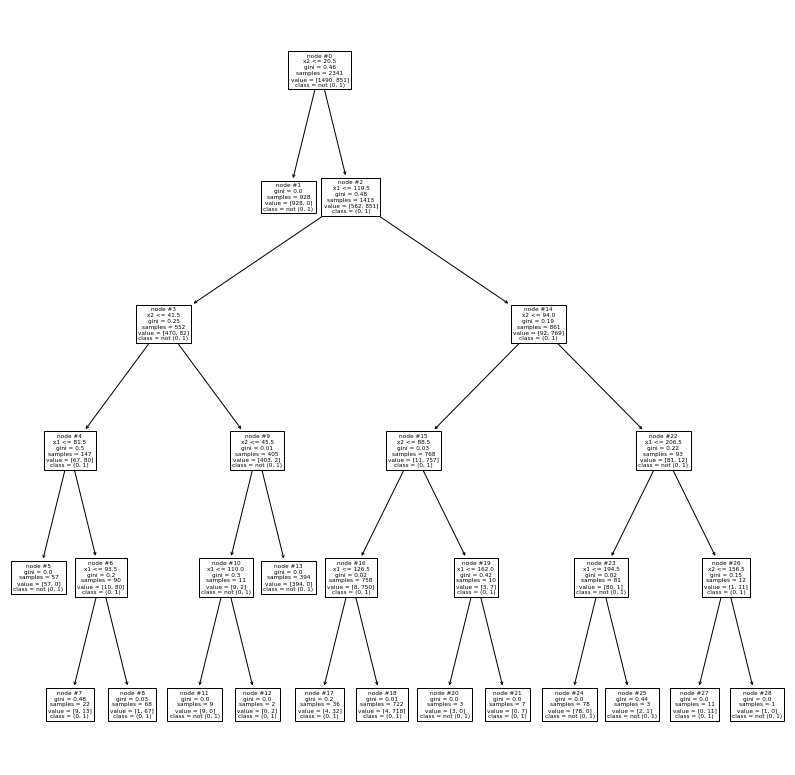

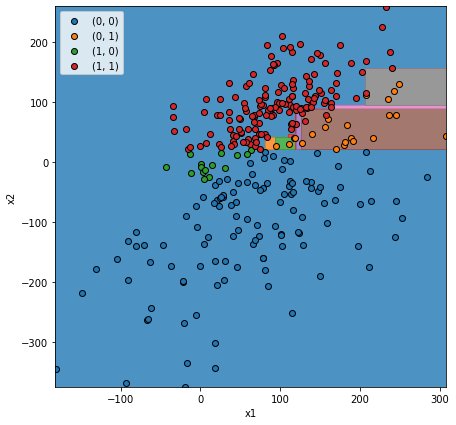

In [14]:
explain(max_depth=5)

## $(1, 0)$

In [16]:
focus_class = '(1, 0)'

In [7]:
%%time
explanation = generate_diro2c_explanation(X, 0, comparer, generation_func='global',
                                          focus_class=focus_class, gn_population_size=500)
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 44.1 s, sys: 377 ms, total: 44.5 s
Wall time: 49.9 s


In [17]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [18]:
evaluation_info = explanation['binary_diff_classifer']['evaluation_info']
X_explain, y_explain = evaluation_info['X'], evaluation_info['y']
feature_names = comparer.feature_names
class_names = explanation['class_names']

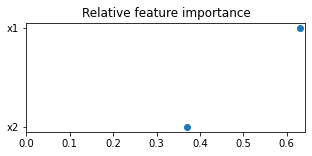

node #6: if (x1 <= 45.5) and (x2 > -61.0) and (x2 <= 26.5) then class (1, 0) (covers 0.925 of 335 instances)

generated data evaluation:
              precision    recall  f1-score   support

  not (1, 0)       0.95      0.98      0.97      1650
      (1, 0)       0.93      0.80      0.86       389

    accuracy                           0.95      2039
   macro avg       0.94      0.89      0.91      2039
weighted avg       0.95      0.95      0.95      2039


original data evaluation:
              precision    recall  f1-score   support

  not (1, 0)       0.99      0.95      0.97       285
      (1, 0)       0.50      0.87      0.63        15

    accuracy                           0.95       300
   macro avg       0.75      0.91      0.80       300
weighted avg       0.97      0.95      0.96       300



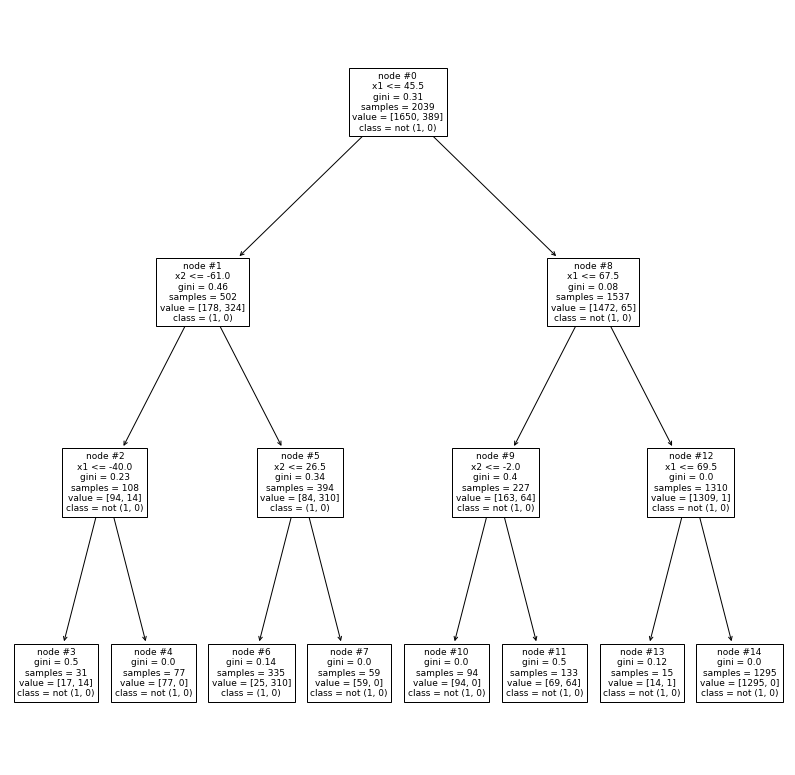

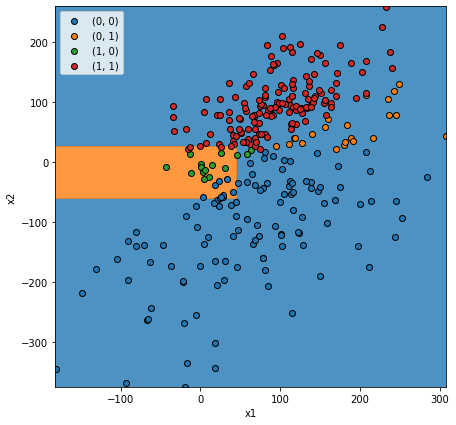

In [20]:
explain(max_depth=3)

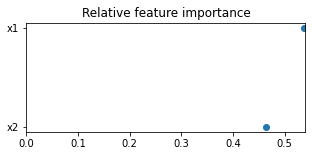

node #10: if (x1 <= 45.5) and (x2 > -42.5) and (x2 <= 26.5) then class (1, 0) (covers 0.982 of 272 instances)
node #16: if (x1 > 45.5) and (x1 <= 67.5) and (x2 > -2.0) and (x2 <= 23.5) then class (1, 0) (covers 1.0 of 64 instances)
node #9: if (x1 <= 45.5) and (x2 > -61.0) and (x2 <= -42.5) then class (1, 0) (covers 0.683 of 63 instances)
node #5: if (x1 <= -40.0) and (x2 > -115.5) and (x2 <= -61.0) then class (1, 0) (covers 0.875 of 16 instances)

generated data evaluation:
              precision    recall  f1-score   support

  not (1, 0)       1.00      0.98      0.99      1650
      (1, 0)       0.93      1.00      0.97       389

    accuracy                           0.99      2039
   macro avg       0.97      0.99      0.98      2039
weighted avg       0.99      0.99      0.99      2039


original data evaluation:
              precision    recall  f1-score   support

  not (1, 0)       1.00      0.95      0.97       285
      (1, 0)       0.52      1.00      0.68        15

  

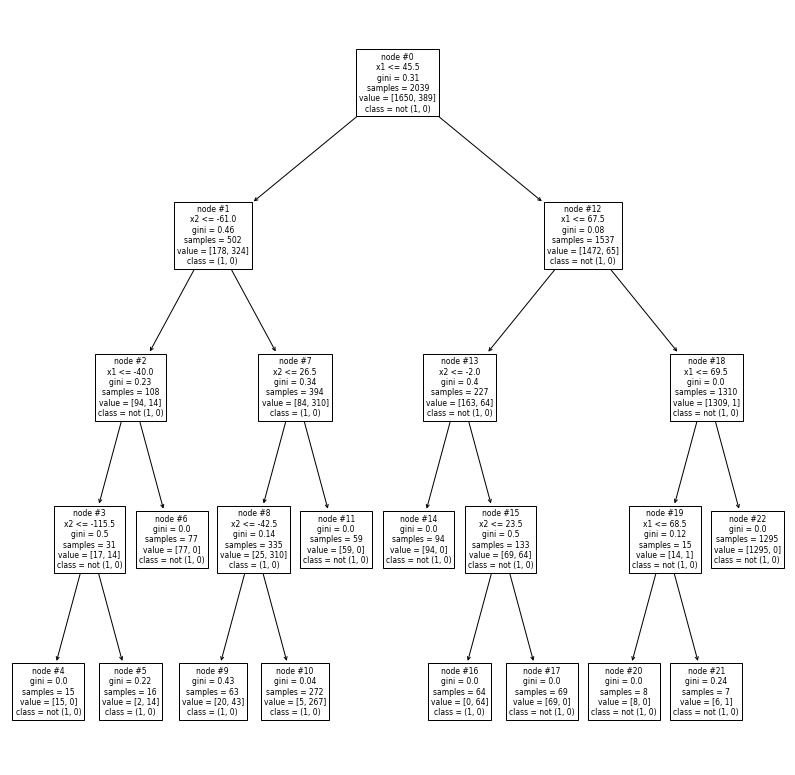

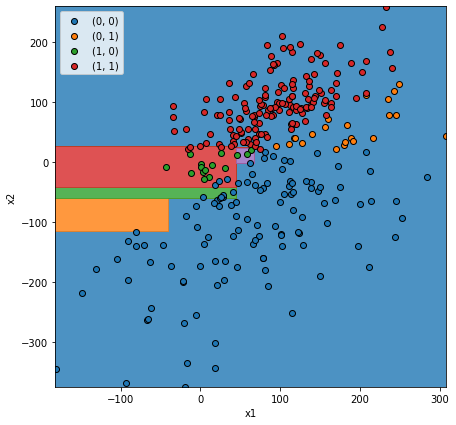

In [21]:
explain(max_depth=4)

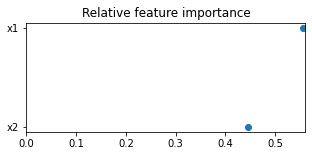

node #16: if (x1 <= 45.5) and (x2 > -21.5) and (x2 <= 26.5) then class (1, 0) (covers 0.995 of 219 instances)
node #22: if (x1 > 45.5) and (x1 <= 67.5) and (x2 > -2.0) and (x2 <= 23.5) then class (1, 0) (covers 1.0 of 64 instances)
node #15: if (x1 <= 45.5) and (x2 > -42.5) and (x2 <= -21.5) then class (1, 0) (covers 0.925 of 53 instances)
node #12: if (x1 <= -9.0) and (x2 > -61.0) and (x2 <= -42.5) then class (1, 0) (covers 1.0 of 43 instances)
node #7: if (x1 <= -40.0) and (x2 > -96.5) and (x2 <= -61.0) then class (1, 0) (covers 1.0 of 11 instances)
node #6: if (x1 <= -40.0) and (x2 > -115.5) and (x2 <= -96.5) then class (1, 0) (covers 0.6 of 5 instances)

generated data evaluation:
              precision    recall  f1-score   support

  not (1, 0)       1.00      1.00      1.00      1650
      (1, 0)       0.98      1.00      0.99       389

    accuracy                           1.00      2039
   macro avg       0.99      1.00      0.99      2039
weighted avg       1.00      1.00 

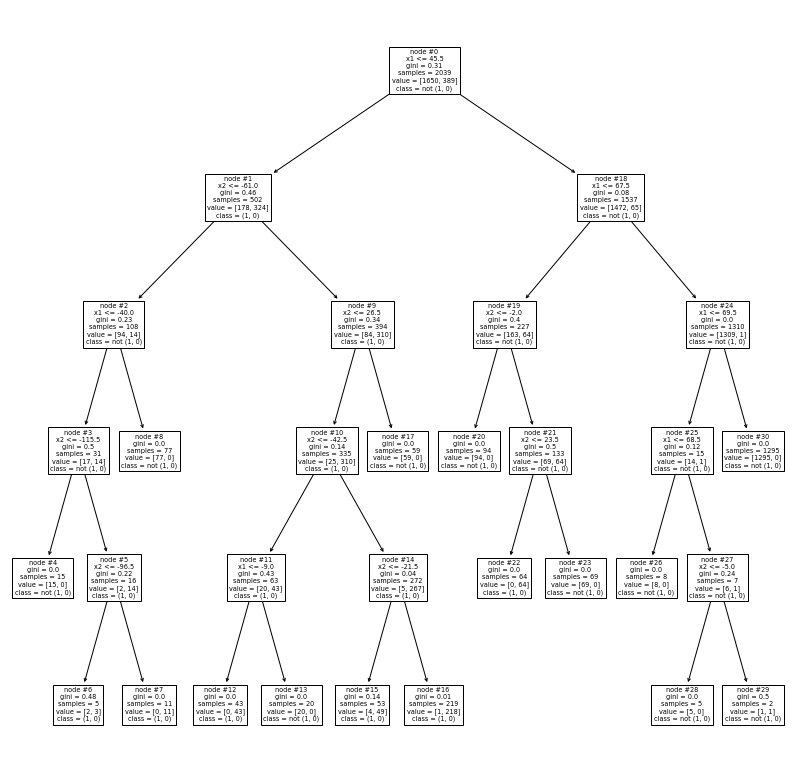

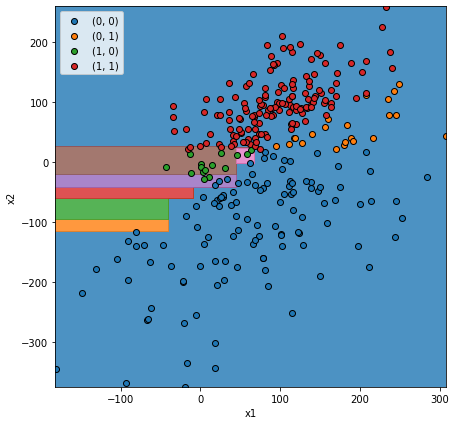

In [22]:
explain(max_depth=5)